# Michał Filipiuk - 385423
## SAD assignment

### Imports

In [1]:
library(car)
library(caret)
library(purrr)
library(tidyr)
library(ggplot2)
library(reshape)
library(MASS)
library(Metrics)
library(lightgbm)
library(glmnet)

Loading required package: carData
Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: ‘purrr’

The following object is masked from ‘package:caret’:

    lift

The following object is masked from ‘package:car’:

    some


Attaching package: ‘reshape’

The following objects are masked from ‘package:tidyr’:

    expand, smiths


Attaching package: ‘Metrics’

The following objects are masked from ‘package:caret’:

    precision, recall

Loading required package: R6
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:reshape’:

    expand

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0

### Loading data

#### Cancer data - binary classification

In [2]:
load("cancer.RData")
cancer.data.train <- data.train
cancer.data.test <- data.test

#### Protein - regression

In [17]:
load("protein.RData")
protein.data.train <- data.frame(data.train)
protein.data.test <- data.test

### Data preprocessing

To analyze which columns are categorical and which are numerical, I will count the percent of unique values for each variable. If number is smaller than 1%, I'll classify it as categorical.

Cancer

In [4]:
cancer.categorical.columns <- colnames(cancer.data.train)[sapply(cancer.data.train, function(x){return(length(unique(x))/nrow(cancer.data.train)*100 < 1)})]

In [5]:
length(cancer.categorical.columns) / ncol(cancer.data.train)

[1] 0

Protein

In [18]:
protein.categorical.columns <- colnames(protein.data.train)[sapply(protein.data.train, function(x){return(length(unique(x))/nrow(protein.data.train)*100 < 1)})]

In [19]:
protein.data.train[protein.categorical.columns]  <- lapply(protein.data.train[protein.categorical.columns] , factor)

In [8]:
for(c in protein.categorical.columns){
    levels(protein.data.train[,c]) <- c(0,1)
}

In [9]:
length(protein.categorical.columns) / ncol(protein.data.train)

[1] 0.5002499

As we see, cancer dataset has no categorical variables, while over a half from protein are categorical

In [10]:
sum(is.na(cancer.data.train))

[1] 0

In [11]:
sum(is.na(cancer.data.test))

[1] 0

In [12]:
sum(is.na(protein.data.train))

[1] 0

In [13]:
sum(is.na(protein.data.test))

[1] 0

Perfect! Our data has no missing values!

### Building model

In [14]:
CV = function(formula, model, data, number.of.folds = 5, Y="Y"){
    fold.cut <-sample(cut(1:(dim(data)[1]), breaks = number.of.folds, labels = FALSE))
    mse.list = vector()
    for(i in 1:number.of.folds){
        train.data <- data[-(fold.cut == i), ]
        test.data <- data[(fold.cut == i), ]
        trained.model <- model(formula, data = train.data)
        x <- predict(trained.model, newdata = test.data)
        mse.list[i] <- mse(test.data$Y, x)    
    }
    print(mean(mse.list))
}

#### Protein

##### Linear regression

In [40]:
fit = glmnet(as.matrix(protein.data.train[, !names(protein.data.train) %in% c("Y")]), protein.data.train$Y, alpha = 1)

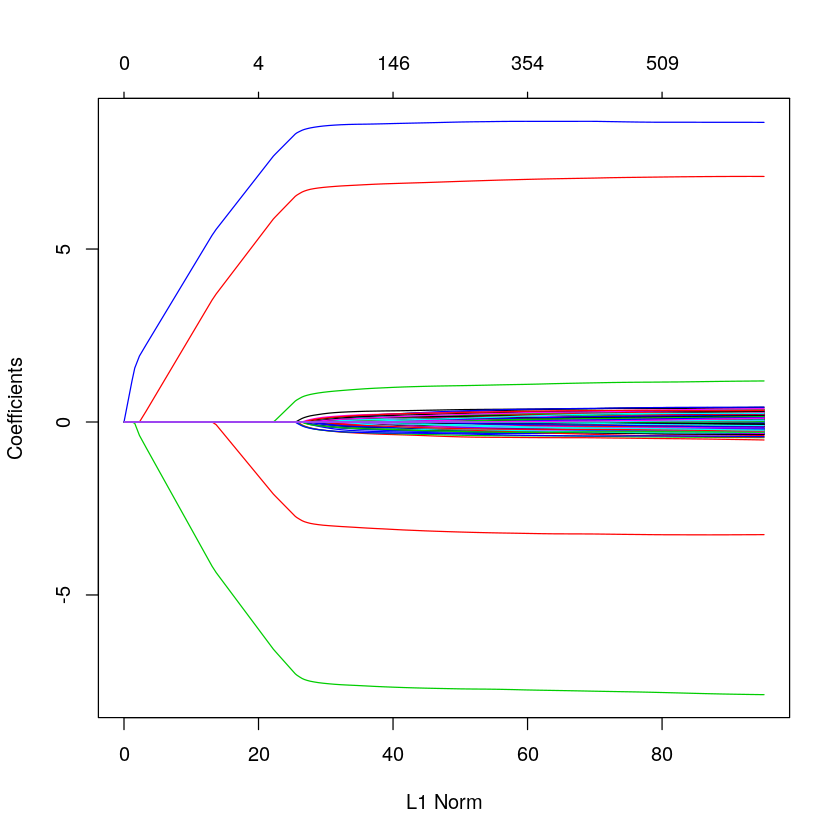

In [41]:
plot(fit)

In [33]:
tmp_coeffs <- coef(fit, s = fit$lambda[50])
data.frame(name = tmp_coeffs@Dimnames[[1]][tmp_coeffs@i + 1], coefficient = tmp_coeffs@x)

name,coefficient
(Intercept),16.2474851
x1623,8.2088786
x1764,6.4046415
x1028,0.4937093
x420,-7.1493013
x456,-2.6098243


In [37]:
CV(Y ~ 1 + x1623 + x1764 + x1028 + x420 + x456, data = protein.data.train, model=lm)

[1] 36.72422


In [38]:
best.features.protein <- c("x1623","x1764","x1028","x420","x456")

##### LightGBM

In [102]:
number.of.folds <- 5
data <- protein.data.train[,c(best.features.protein,"Y")]
fold.cut <-sample(cut(1:(dim(data)[1]), breaks = number.of.folds, labels = FALSE))
mse.list = vector()
for(i in 1:number.of.folds){
    train.data <- data[-(fold.cut == i), ]
    test.data <- data[(fold.cut == i), ]
    trained.model <- lightgbm(data = data.matrix(train.data[, !names(train.data) %in% c("Y")]), label = data.train.data[,"Y"], obj = "regression", learning_rate=0.05, verbose=0, nrounds=10, num_leaves=7, max_bin=7, max_depth=4)
    print(mse(train.data$Y, predict(trained.model, as.matrix(train.data))))
    x <- predict(trained.model, as.matrix(test.data))
    #print(mse(test.data$Y, x) )
    mse.list[i] <- mse(test.data$Y, x)    
}
print(mean(mse.list))

[1] 261.0108
[1] 261.0108
[1] 261.0108
[1] 261.0108
[1] 261.0108
[1] 260.7511


In [86]:
lgbm.train <- lgb.Dataset(as.matrix(protein.data.train[, best.features.protein]) , label=protein.data.train$Y)
params <- list(objective="regression_l2", metric="mse")
model <- lgb.cv(params, lgbm.train, 200, nfold=5, learning_rate=0.05, early_stopping_rounds=20, num_leaves=255, max_bin=255)

[1]:	valid's l2:243.217+36.4532 
[2]:	valid's l2:229.507+36.3655 
[3]:	valid's l2:217.17+35.9698 
[4]:	valid's l2:205.897+35.8623 
[5]:	valid's l2:195.711+35.6266 
[6]:	valid's l2:186.649+35.7943 
[7]:	valid's l2:177.883+35.4934 
[8]:	valid's l2:169.936+35.6912 
[9]:	valid's l2:162.516+35.5775 
[10]:	valid's l2:155.633+35.3508 
[11]:	valid's l2:149.727+35.493 
[12]:	valid's l2:144.345+35.27 
[13]:	valid's l2:139.078+35.3109 
[14]:	valid's l2:134.169+35.2663 
[15]:	valid's l2:130.027+35.2393 
[16]:	valid's l2:126.082+35.3658 
[17]:	valid's l2:122.215+35.3253 
[18]:	valid's l2:119.038+35.5828 
[19]:	valid's l2:115.861+35.6331 
[20]:	valid's l2:112.953+35.6375 
[21]:	valid's l2:110.272+35.5431 
[22]:	valid's l2:107.77+35.5365 
[23]:	valid's l2:105.346+35.835 
[24]:	valid's l2:103.091+35.8742 
[25]:	valid's l2:101.166+35.9583 
[26]:	valid's l2:99.5193+36.2155 
[27]:	valid's l2:97.7566+35.9668 
[28]:	valid's l2:96.1796+35.9936 
[29]:	valid's l2:94.4494+35.8053 
[30]:	valid's l2:92.9368+35.6

In [72]:
? lgb.cv

#### Cancer data

##### Logistic regression

In [44]:
fit = glmnet(as.matrix(cancer.data.train[, !names(cancer.data.train) %in% c("Y")]), cancer.data.train$Y, alpha = 0)

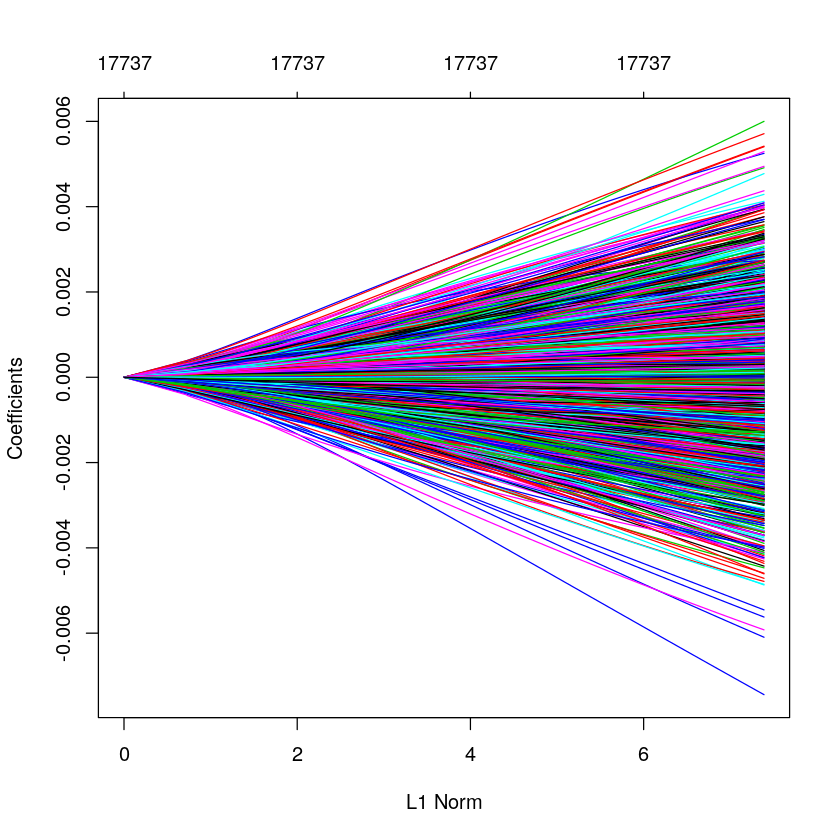

In [45]:
plot(fit)

##### Random Forest

##### LightGBM

### Analyzing most important variables

#### Protein

##### Vif

#### Cancer

##### Vif

### Saving data

In [ ]:
stepAIC(lm(Y ~ 1, data = protein.data.train), direction = "forward", scope=list(upper=lm(Y ~ ., data = protein.data.train),lower=lm(Y ~ 1, data = protein.data.train)), trace = 2)

In [ ]:
stepAIC(lm(Y ~ 1, data = protein.data.train), direction = "forward", scope=list(upper=lm(Y ~ ., data = protein.data.train),lower=lm(Y ~ 1, data = protein.data.train)), trace = 2, k=log(nrow(protein.data.train)))

In [ ]:
model = lm(Y ~ x1623 + x420 + x1764 + x456 + x1028 + x1868 + x1756 + x1104 + 
    x410 + x1064 + x223 + x289 + x1027 + x497 + x1894 + x676 + 
    x1200 + x686 + x1316 + x1789 + x1934 + x1559 + x1683 + x996 + 
    x1418 + x1102 + x1109 + x1745 + x1946 + x148 + x843 + x928 + 
    x457 + x1860 + x1019 + x1443 + x1536 + x458 + x1979 + x737 + 
    x212 + x1943 + x1219 + x535 + x91, data = protein.data.train)

In [ ]:
summary(model)

In [ ]:
vif(lm(Y ~ ., data = protein.data.train))

In [ ]:
x <- alias(lm(Y ~ ., data = protein.data.train))

In [ ]:
typeof(x$Complete)

In [ ]:
x.complete <- x$Complete

In [ ]:
?alias

In [ ]:
sort(rownames(x.complete))

In [ ]:
sort(colnames(x.complete))

In [ ]:
length(intersect(colnames(protein.data.train),rownames(x.complete)))

In [ ]:
length(rownames(x.complete))

In [ ]:
? cast

In [ ]:
? stepAIC

In [89]:
?lightgbm